### Simulator calibration

Code for fidgeting with simulator to get it near T5 dataset characteristics


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm_utils import *
from simulation import * 
import simulation_utils 

# for a reproducible result
np.random.seed(1)
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [2]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = simulation_utils.generateUnits(n_units = nUnits, SNR = SNR)
calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise= 0.3, nSteps= nTrainingSteps)


lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

In [3]:
# Do a quick sweep of cursor gains to find the optimal one for this task:
figSize(5,5)

cfg = dict()
cfg['neuralTuning'] = initialTuning
cfg['D']            = D
cfg['alpha']        = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
cfg['delT']         = 0.02 # define the time step (20 ms)
cfg['nDelaySteps']  = 10   # define the simulated user's visual feedback delay (200 ms)
cfg['nSimSteps']    = 10000

possibleGain = np.linspace(0.1,2.5,10)
cfg['beta']  = simulation_utils.gainSweep(cfg, possibleGain, verbose = True)


print('Using gain value beta = ', cfg['beta'])

0 / 10


../utils/simulation/simulation.py:193: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:196: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  0.6333333333333333


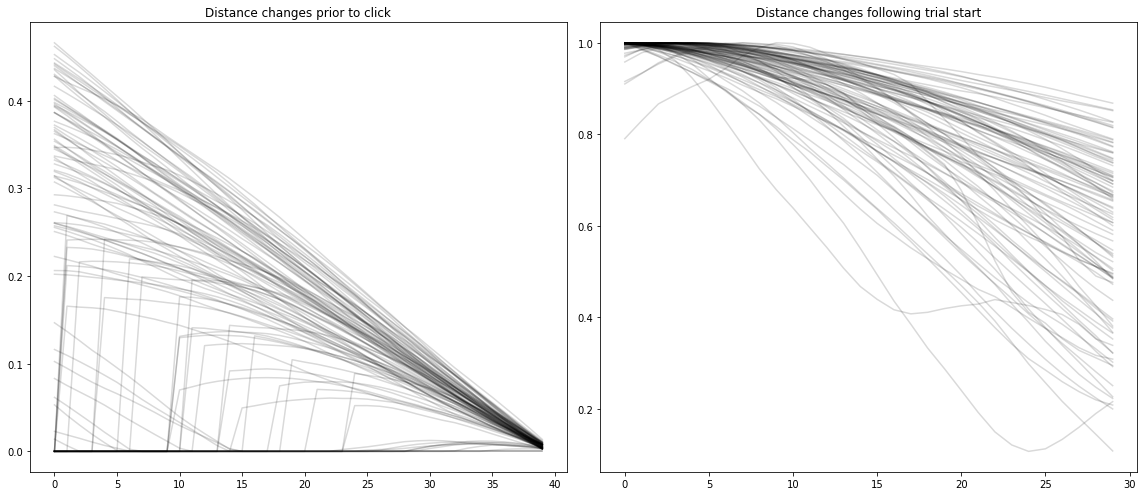

In [4]:
figSize(7, 16)

results = simulateBCIFitts(cfg)

lookback   = 40
nHoldSteps = 50

plt.subplot(1, 2, 1)
plt.title('Distance changes prior to click')
for t in results['trialStart']:
    dist  = np.linalg.norm(results['posTraj'][(t - nHoldSteps - lookback):(t - nHoldSteps), :] - results['targTraj'][(t - nHoldSteps - lookback):(t - nHoldSteps), :], axis = 1)
    dist  = np.maximum(dist - 0.0725, 0)
    plt.plot(dist, color = 'k', alpha = 0.15)
    
    
plt.subplot(1, 2, 2)
plt.title('Distance changes following trial start')
for i, t in enumerate(results['trialStart']):
    dist  = np.linalg.norm(results['posTraj'][t:(t + 30), :] - results['targTraj'][t:(t + 30), :], axis = 1)
    dist /= dist.max()
    plt.plot(dist, color = 'k', alpha = 0.15)
    
plt.tight_layout()
plt.show()

In [5]:
def sampleSNR():
    a, b, loc, scale = 4.904613603871817, 1358376.9875482046, 0.3669615703933665, 372538.74919432227
    sample_SNR       = (np.random.beta(a, b) * scale/2.5) 
    
    return sample_SNR

In [24]:
from metrics import estimateSNR
import sklearn, copy

figSize(7, 7)

# Setup settings:
nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000
  

# simulator settings:
cfg = dict()
cfg['nDelaySteps'] = 10    # define the simulated user's visual feedback delay (200 ms)
cfg['nSimSteps']   = 10000
cfg['delT']        = 0.02  # define the time step (10 ms)
cfg['alpha']       = 0.94  # amount of exponential smoothing (0.9 to 0.96 are reasonable)

# SNR calc settings:
nReps           = 100
thresh          = 0.3   # only calculate SNR using points far from target
cutStart        = 7     # exclude first <cutStart> timesteps

SNRvals = np.zeros((nReps,))
corrs   = np.zeros((nReps,))
R2s     = np.zeros((nReps,))

for n in range(nReps):
    
    sample_SNR             = sampleSNR()
    initialTuning          = simulation_utils.generateUnits(n_units = nUnits, SNR = sample_SNR)
    calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    rep_cfg = copy.deepcopy(cfg)
    rep_cfg['neuralTuning'] = initialTuning
    rep_cfg['D']            = D
    rep_cfg['beta']         = simulation_utils.gainSweep(rep_cfg, possibleGain)
    
    rep_result          = simulateBCIFitts(rep_cfg)
    SNRvals[n], usedIdx = estimateSNR(rep_result['neuralTraj'], rep_result['posTraj'], rep_result['targTraj'], 
                                      rep_result['trialStart'], thresh, cutStart)
    
    train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(rep_result['neuralTraj'], rep_result['targTraj'] - rep_result['posTraj'],
                                                                               train_size = 0.8)
    
    R2s[n]   = LinearRegression().fit(train_x, train_y).score(test_x, test_y)
    corrs[n] = np.mean(rep_result['ttt'])
    if ( n + 1) % 10 == 0:
        print(n + 1, '/', nReps, ' complete.')

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


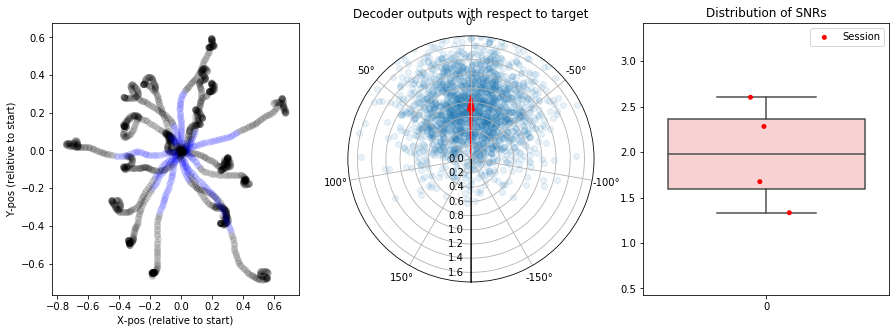

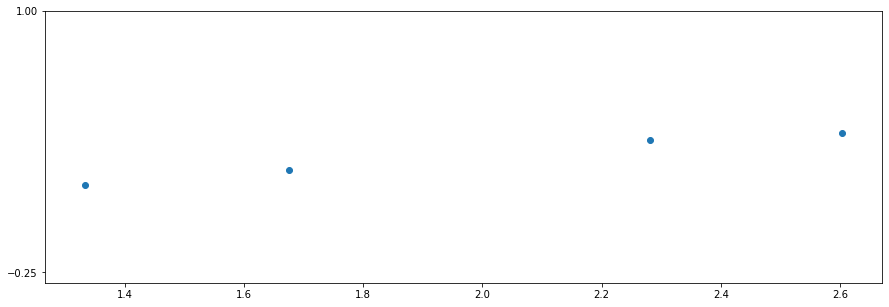

In [32]:
import seaborn as sns
from CosineTuning import getAngles
from plotting_utils import modifyBoxPlotAlpha

figSize(5, 15)

# example trials with delineated timepoints used in SNR calculation:
plt.subplot(1, 3, 1)
for i in range(30, 50):
    start = int(rep_result['trialStart'][i])
    stop  = int(rep_result['trialStart'][i+1] - 1)

    trlTraj          = rep_result['posTraj'][start:stop, :] 
    trlTraj_centered = trlTraj - rep_result['posTraj'][start, :]
    
    used   = np.in1d(np.arange(start, stop), usedIdx) 
    unused = ~ used

    _ = plt.scatter(trlTraj_centered[used, 0], trlTraj_centered[used, 1], color = 'b', alpha = 0.1)
    _ = plt.scatter(trlTraj_centered[unused, 0], trlTraj_centered[unused, 1], color = 'k', alpha = 0.1)

    plt.xlabel('X-pos (relative to start)')
    plt.ylabel('Y-pos (relative to start)')

# decoder and point-at-target vector angles, with SNR modeling:
plt.subplot(132, projection = 'polar')
cursorErr = rep_result['targTraj'] - rep_result['posTraj']
dists     = np.linalg.norm(cursorErr[usedIdx, :], axis = 1)
p_t       = cursorErr[usedIdx, :] / dists[:, np.newaxis]  # unit vector pointing at target
u_t       = lr.predict(rep_result['neuralTraj'][usedIdx, :])  
mult      = np.linalg.lstsq(p_t, u_t, rcond = None)[0][0][0]
res       = u_t - (p_t * mult)
SNR       = mult / np.std(res)
angles    = getAngles(u_t, p_t) * np.sign(np.cross(p_t, u_t)) # get absolute angle deviation not inner angle
magn      = np.linalg.norm(u_t, axis = 1)

plt.scatter(angles, magn, alpha = 0.1)
plt.arrow(0, 0, 0, mult, color = 'r', width=0.05, alpha  = 1)
ax = plt.gca()
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(179.9)
plt.title('Decoder outputs with respect to target')

# distribution of SNRs across randomly initialized instances of simulator:
plt.subplot(1, 3, 3)
plt.title('Distribution of SNRs')
sns.boxplot(data = SNRvals, orient = 'v', color = 'r')
ax = plt.gca()
modifyBoxPlotAlpha(ax, 0.2)
sns.stripplot(data = SNRvals, orient = 'v', color = 'r', label = 'Session', jitter = 0.1)
plt.ylim((0.43069608025352757, 3.419542032677601))
plt.legend()

plt.savefig(fig_path + 'SNR/simulator_exampleAndAllSNRs', format = 'pdf')
plt.show()

plt.figure()
plt.scatter(SNRvals, R2s)
plt.ylim([-0.3, 1])
plt.yticks([-0.25, 1])
#plt.savefig(fig_path + 'SNR/simulator_SNR_vs_R2', format = 'pdf')
plt.show()

both R$^{2}$ and SNR seem to be in T5 range (median T5 SNR = 1.5,  R$^{2}$ usually in 0.3 area). Now let's see how our subspace shift dynamics match up to that of T5 as determined by cos(theta).


In [8]:


def simulateDrift(nUnits, nDays, tuning_shift):
    
    
    cos_angles = np.zeros((n_days, 2))
    
    init_SNR       = sampleSNR() 
    initialTuning  = generateUnits(n_units = nUnits, SNR = init_SNR)
    tuning         = np.copy(initialTuning)
    
    calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    initEnc                = fitEncodingMatrix(calVelocity, calNeural, fitMean = False)
    initEnc               /= np.linalg.norm(initEnc, axis = 0)
    
    for j in range(n_days):
        tuning = simulateTuningShift(tuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], 
                                     mean_shift = tuning_shift[2], renormalize = renormalize)

        calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
        enc                    = fitEncodingMatrix(calVelocity, calNeural, fitMean = False)
        enc                   /= np.linalg.norm(enc, axis = 0)

        cos_angles[j, :] = np.diag(enc.dot(initEnc.T))
        
    return cos_angles 

    
    

In [24]:
from joblib import Parallel, delayed
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between


# general settings:
nUnits         = 192
nTrainingSteps = 10000
n_repeats      = 100
tuning_shift   = [0.89, 1, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
max_stretch    = 14              # simulate n_repeats random chains of nonstationarities out this many days

#-----------------------------------------
cos_angles     = np.zeros((n_repeats, max_stretch, 2, )) 


for i in range(n_repeats):
    init_SNR       = sampleSNR() 
    initialTuning  = simulation_utils.generateUnits(n_units = nUnits, SNR = init_SNR)
    tuning         = np.copy(initialTuning)
    
    calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    initEnc                = fitEncodingMatrix(calVelocity, calNeural, fitMean = True)
    initEnc               /= np.linalg.norm(initEnc, axis = 1)[:, None]
    
    for j in range(max_stretch):
        tuning = simulation_utils.simulateTuningShift(tuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], 
                                     mean_shift = tuning_shift[2], renormalize = sampleSNR() )     
        
        calNeural, calVelocity = simulation_utils.simulateUnitActivity(tuning, noise = 0.3, nSteps= nTrainingSteps)
        enc                    = fitEncodingMatrix(calVelocity, calNeural, fitMean = True)
        enc                   /= np.linalg.norm(enc, axis = 1)[:, None]

        cos_angles[i, j, :] = np.diag(enc.dot(initEnc.T))
        
    if (i + 1) % 10 == 0:
        print(i + 1, '/', n_repeats)
        
diffs      = np.concatenate([i * np.ones((n_repeats)) for i in range(1, max_stretch + 1)])

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


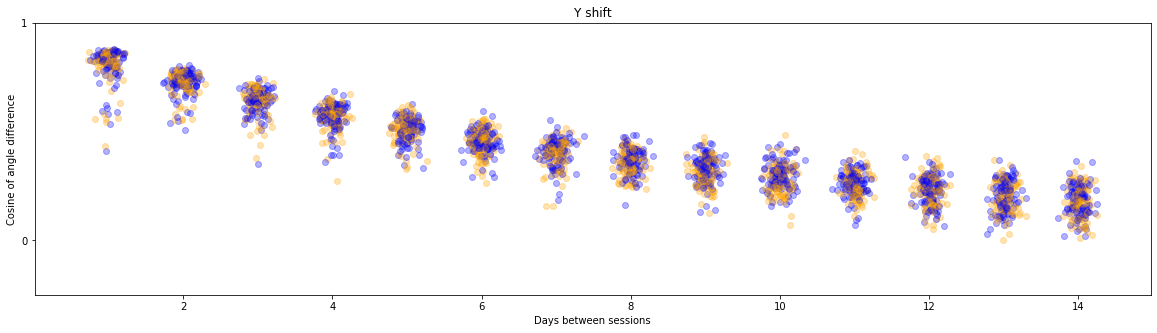

In [27]:
figSize(5, 20)

labels = ['X shift', 'Y shift']
colors = ['b', 'orange']

for i in range(n_repeats):
    for j, label in enumerate(labels):
        thetas = cos_angles[i, :, j]
        plt.scatter(np.arange(1, max_stretch + 1) + np.random.normal(loc = 0, scale = 0.1, size = (max_stretch)), 
                    thetas, c = colors[j], alpha = 0.3)
            
plt.title(label)
plt.ylim([-0.25, 1])
plt.yticks([0, 1])
plt.xlabel('Days between sessions')
plt.ylabel('Cosine of angle difference')
plt.savefig(fig_path + 'SNR/simulator_EncoderDrift_14days', format = 'pdf')
plt.show()